# Arabic Short Answer Grading — Sentence-BERT + BiLSTM

This notebook provides a complete pipeline for automated short answer grading in Arabic. It
follows these steps:
1. Environment setup and imports
2. Dataset upload and robust preprocessing
3. Exploratory data analysis (distribution, correlations, boxplots)
4. Sentence-BERT embeddings for student and model answers
5. BiLSTM regression model implemented as functions
6. Grid search hyperparameter tuning (units, batch size, learning rate)
7. Evaluation with MSE, RMSE, Pearson correlation and tolerance-based accuracy
8. Diagnostic plots (predicted vs actual, residuals, error histogram, training curves)
9. Save best model and encoder to Google Drive


In [1]:
import sys, subprocess, importlib
def ensure_pkg(pkg):
    name = pkg.split('==')[0]
    try:
        importlib.import_module(name)
    except Exception:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])

required = [
    'pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn',
    'sentence-transformers', 'tensorflow', 'scipy', 'arabic-reshaper', 'python-bidi'
]
for p in required:
    ensure_pkg(p)

import os
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from google.colab import drive

sns.set(style='whitegrid')
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print('Environment ready.')

Environment ready.


In [ ]:
# 2. Mount Google Drive to save models (user will be asked to authorize)
def mount_drive():
    drive.mount('/content/drive')

print('If you want to save models to Drive, run: mount_drive()')


In [2]:
# 3. Upload dataset and initial load
from google.colab import files

df = pd.read_csv("/content/AR-ASAG-Dataset - AR-ASAG-Dataset (1).csv")
print('Dataset loaded. Shape:', df.shape)
df.head()

Dataset loaded. Shape: (2133, 6)


,Answer_ID,Question_Type,Question_Arabic,Model_Arabic,Answer_Arabic,Average_Mark
0,1,Define,عرف مصطلح الجريمة الإلكترونية,هي كل سلوك غير قانوني يتم باستخدام الأجهزة الإ...,هي سلوك غير أخلاقي يتم عن طريق وسائل الكترونية...,3.000
1,2,Define,عرف مصطلح الجريمة الإلكترونية,هي كل سلوك غير قانوني يتم باستخدام الأجهزة الإ...,هي كل سلوك غير أخلاقي يتم بواسطة الاجهزة الالك...,5.000
2,3,Define,عرف مصطلح الجريمة الإلكترونية,هي كل سلوك غير قانوني يتم باستخدام الأجهزة الإ...,هي سلوك غير قانوني يحمل باستعمال الأجهزة الالك...,2.625
3,4,Define,عرف مصطلح الجريمة الإلكترونية,هي كل سلوك غير قانوني يتم باستخدام الأجهزة الإ...,هي سلوك غير قانوني تستخدم الوسائل الالكترونية ...,4.000
4,5,Define,عرف مصطلح الجريمة الإلكترونية,هي كل سلوك غير قانوني يتم باستخدام الأجهزة الإ...,هي كل سلوك غير أخلاقي يتم باستخدام الوسائل الا...,3.500


In [3]:
# 4. Preprocessing functions
import arabic_reshaper
from bidi.algorithm import get_display

def clean_text(text):
    """Perform light Arabic normalization and cleaning."""
    if not isinstance(text, str):
        return ''
    # Normalize alef variants and ya
    text = re.sub('[إأآا]', 'ا', text)
    text = re.sub('[يى]', 'ي', text)
    text = re.sub('ة', 'ه', text)
    # Remove diacritics and tatweel
    text = re.sub('[\u0610-\u061A\u064B-\u065F\u0670\u06D6-\u06ED]', '', text)
    text = re.sub('ـ', '', text)
    # Remove punctuation (keep Arabic letters and digits and whitespace)
    text = re.sub('[^\u0600-\u06FF0-9\s]', ' ', text)
    text = re.sub('\s+', ' ', text).strip()
    return text

def preprocess_dataframe(df):
    """Apply cleaning, drop missing, and prepare columns."""
    df = df.copy()
    # Standardize column names if necessary
    expected = ['Answer_ID', 'Question_Type', 'Question_Arabic', 'Model_Arabic', 'Answer_Arabic', 'Average_Mark']
    missing = [c for c in expected if c not in df.columns]
    if missing:
        raise ValueError(f'Missing expected columns: {missing}')
    # Drop exact duplicates
    df = df.drop_duplicates()
    # Drop rows with empty student answers
    df = df.dropna(subset=['Answer_Arabic'])
    # Clean text columns
    df['Answer_clean'] = df['Answer_Arabic'].astype(str).apply(clean_text)
    df['Model_clean'] = df['Model_Arabic'].astype(str).apply(clean_text)
    # Convert target to numeric and drop NaNs
    df['Average_Mark'] = pd.to_numeric(df['Average_Mark'], errors='coerce')
    df = df.dropna(subset=['Average_Mark']).reset_index(drop=True)
    return df

df = preprocess_dataframe(df)
print('After preprocessing shape:', df.shape)
df[['Answer_Arabic','Answer_clean','Model_Arabic','Model_clean','Average_Mark']].head()

<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1959503800.py:17: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('[^\u0600-\u06FF0-9\s]', ' ', text)
/tmp/ipython-input-1959503800.py:18: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('\s+', ' ', text).strip()


After preprocessing shape: (2132, 8)


,Answer_Arabic,Answer_clean,Model_Arabic,Model_clean,Average_Mark
0,هي سلوك غير أخلاقي يتم عن طريق وسائل الكترونية...,هي سلوك غير اخلاقي يتم عن طريق وسائل الكترونيه...,هي كل سلوك غير قانوني يتم باستخدام الأجهزة الإ...,هي كل سلوك غير قانوني يتم باستخدام الاجهزه الا...,3.000
1,هي كل سلوك غير أخلاقي يتم بواسطة الاجهزة الالك...,هي كل سلوك غير اخلاقي يتم بواسطه الاجهزه الالك...,هي كل سلوك غير قانوني يتم باستخدام الأجهزة الإ...,هي كل سلوك غير قانوني يتم باستخدام الاجهزه الا...,5.000
2,هي سلوك غير قانوني يحمل باستعمال الأجهزة الالك...,هي سلوك غير قانوني يحمل باستعمال الاجهزه الالك...,هي كل سلوك غير قانوني يتم باستخدام الأجهزة الإ...,هي كل سلوك غير قانوني يتم باستخدام الاجهزه الا...,2.625
3,هي سلوك غير قانوني تستخدم الوسائل الالكترونية ...,هي سلوك غير قانوني تستخدم الوسائل الالكترونيه ...,هي كل سلوك غير قانوني يتم باستخدام الأجهزة الإ...,هي كل سلوك غير قانوني يتم باستخدام الاجهزه الا...,4.000
4,هي كل سلوك غير أخلاقي يتم باستخدام الوسائل الا...,هي كل سلوك غير اخلاقي يتم باستخدام الوسائل الا...,هي كل سلوك غير قانوني يتم باستخدام الأجهزة الإ...,هي كل سلوك غير قانوني يتم باستخدام الاجهزه الا...,3.500


Target statistics:
count    2132.000000
mean        2.901208
std         1.403705
min         0.000000
25%         1.750000
50%         3.000000
75%         4.000000
max         5.000000
Name: Average_Mark, dtype: float64


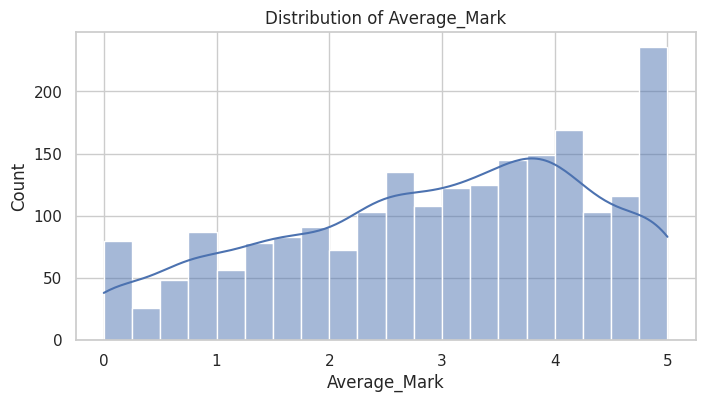

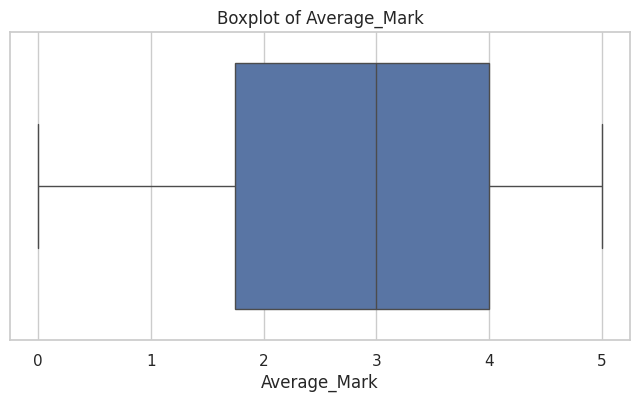

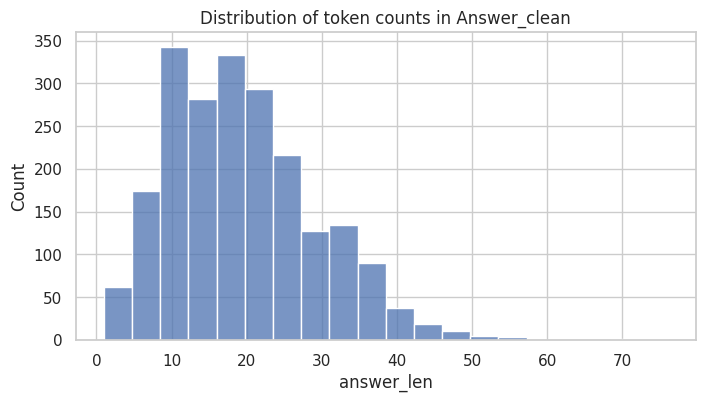

Pearson correlation between answer length and mark: 0.3545


In [4]:
# 5. Exploratory Data Analysis (numerical summaries and plots)
def eda_plots(df):
    print('Target statistics:')
    print(df['Average_Mark'].describe())
    plt.figure(figsize=(8,4))
    sns.histplot(df['Average_Mark'], bins=20, kde=True)
    plt.title('Distribution of Average_Mark')
    plt.show()
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df['Average_Mark'])
    plt.title('Boxplot of Average_Mark')
    plt.show()
    # Length-based features
    df['answer_len'] = df['Answer_clean'].apply(lambda x: len(x.split()))
    plt.figure(figsize=(8,4))
    sns.histplot(df['answer_len'], bins=20, kde=False)
    plt.title('Distribution of token counts in Answer_clean')
    plt.show()
    # Correlation of length with mark
    corr, _ = pearsonr(df['answer_len'], df['Average_Mark'])
    print(f'Pearson correlation between answer length and mark: {corr:.4f}')

eda_plots(df)


In [5]:
# 6. Load SBERT encoder and create embeddings
SBERT_NAME = 'paraphrase-multilingual-MiniLM-L12-v2'
def load_sbert(name=SBERT_NAME):
    print('Loading SBERT model:', name)
    return SentenceTransformer(name)

sbert = load_sbert()
def embed_texts(sbert_model, texts, batch_size=64):
    return sbert_model.encode(texts, batch_size=batch_size, show_progress_bar=True)

student_texts = df['Answer_clean'].tolist()
model_texts = df['Model_clean'].tolist()
emb_student = embed_texts(sbert, student_texts)
emb_model = embed_texts(sbert, model_texts)

print('Embeddings computed. Shapes:', emb_student.shape, emb_model.shape)


Loading SBERT model: paraphrase-multilingual-MiniLM-L12-v2


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/34 [00:00<?, ?it/s]

Batches:   0%|          | 0/34 [00:00<?, ?it/s]

Embeddings computed. Shapes: (2132, 384) (2132, 384)


In [6]:
# 7. Prepare X, y and train/val/test split
def prepare_dataset(emb_student, emb_model, targets, test_size=0.2, val_size=0.1, random_state=RANDOM_SEED):
    # Concatenate embeddings (student || model) as features
    X = np.hstack([emb_student, emb_model])
    y = np.array(targets, dtype=np.float32)
    # Split train/test
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    # Split train-> train/val
    val_relative = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=val_relative, random_state=random_state)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(emb_student, emb_model, df['Average_Mark'].values)
print('Shapes:')
print('X_train', X_train.shape, 'X_val', X_val.shape, 'X_test', X_test.shape)


Shapes:
X_train (1491, 768) X_val (214, 768) X_test (427, 768)


In [7]:
# 8. Reshape for BiLSTM: convert (n_samples, emb_dim) -> (n_samples, timesteps, features)
def reshape_for_lstm(X, timesteps=8):
    n, emb = X.shape
    if emb % timesteps == 0:
        features = emb // timesteps
        return X.reshape(n, timesteps, features)
    else:
        # If not divisible, pad with zeros to next multiple
        next_mult = ((emb + timesteps - 1) // timesteps) * timesteps
        pad_width = next_mult - emb
        Xpad = np.pad(X, ((0,0),(0,pad_width)), mode='constant')
        features = Xpad.shape[1] // timesteps
        return Xpad.reshape(n, timesteps, features)

TIMESTEPS = 8
X_train_seq = reshape_for_lstm(X_train, timesteps=TIMESTEPS)
X_val_seq = reshape_for_lstm(X_val, timesteps=TIMESTEPS)
X_test_seq = reshape_for_lstm(X_test, timesteps=TIMESTEPS)

print('Sequence shapes:', X_train_seq.shape, X_val_seq.shape, X_test_seq.shape)


Sequence shapes: (1491, 8, 96) (214, 8, 96) (427, 8, 96)


In [8]:
# 9. Build BiLSTM model function (parameterized by hyperparameters)
def build_bilstm_model(timesteps, features, lstm_units=128, learning_rate=1e-3, dropout=0.2):
    inp = layers.Input(shape=(timesteps, features))
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(inp)
    x = layers.Bidirectional(layers.LSTM(max(lstm_units//2, 16)))(x)
    if dropout and dropout > 0:
        x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(1, activation='linear')(x)
    model = models.Model(inputs=inp, outputs=out)
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model

# Example: build a model to verify shapes
timesteps = X_train_seq.shape[1]
features = X_train_seq.shape[2]
test_model = build_bilstm_model(timesteps, features, lstm_units=64)
test_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8, 96)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 8, 128)         │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,873 (499.50 KB)

 Trainable params: 127,873 (499.50 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# 10. Training function that returns history and validation metrics
def train_evaluate(model, X_tr, y_tr, X_val, y_val, epochs=30, batch_size=32, verbose=0):
    es = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    hist = model.fit(X_tr, y_tr, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[es], verbose=verbose)
    # Evaluate on validation set
    y_val_pred = model.predict(X_val).flatten()
    mse = mean_squared_error(y_val, y_val_pred)
    rmse = np.sqrt(mse)
    p_corr, _ = pearsonr(y_val, y_val_pred)
    return hist, {'mse': mse, 'rmse': rmse, 'pearson': p_corr}

# Quick smoke run (optional)
del test_model


In [10]:
# 11. Hyperparameter grid search (units, batch_size, learning_rate)
def grid_search(param_grid, X_tr, y_tr, X_val, y_val, timesteps, features):
    results = []
    for units in param_grid['lstm_units']:
        for batch in param_grid['batch_size']:
            for lr in param_grid['learning_rate']:
                print(f'Evaluating units={units}, batch={batch}, lr={lr}')
                model = build_bilstm_model(timesteps, features, lstm_units=units, learning_rate=lr, dropout=0.2)
                hist, metrics = train_evaluate(model, X_tr, y_tr, X_val, y_val, epochs=40, batch_size=batch, verbose=0)
                metrics['units'] = units
                metrics['batch'] = batch
                metrics['lr'] = lr
                metrics['history'] = hist
                results.append((metrics, model))
                print(f" -> val rmse={metrics['rmse']:.4f}, pearson={metrics['pearson']:.4f}")
    # Sort by rmse ascending
    results_sorted = sorted(results, key=lambda x: x[0]['rmse'])
    return results_sorted

param_grid = {
    'lstm_units': [64, 128],
    'batch_size': [16, 32],
    'learning_rate': [1e-3, 5e-4]
}
print('Starting grid search...')
grid_results = grid_search(param_grid, X_train_seq, y_train, X_val_seq, y_val, TIMESTEPS, features)
print('Grid search completed.')


Starting grid search...
Evaluating units=64, batch=16, lr=0.001
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step
 -> val rmse=1.1278, pearson=0.6299
Evaluating units=64, batch=16, lr=0.0005
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step
 -> val rmse=1.2039, pearson=0.5614
Evaluating units=64, batch=32, lr=0.001


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
 -> val rmse=1.1297, pearson=0.6405
Evaluating units=64, batch=32, lr=0.0005


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step
 -> val rmse=1.1283, pearson=0.6284
Evaluating units=128, batch=16, lr=0.001
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
 -> val rmse=1.0876, pearson=0.6566
Evaluating units=128, batch=16, lr=0.0005
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step
 -> val rmse=1.1150, pearson=0.6430
Evaluating units=128, batch=32, lr=0.001
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step
 -> val rmse=1.1110, pearson=0.6467
Evaluating units=128, batch=32, lr=0.0005
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step
 -> val rmse=1.1820, pearson=0.5822
Grid search completed.


In [11]:
# 12. Inspect top results and select the best model
def extract_metrics(results, top_k=5):
    records = []
    for metrics, model in results[:top_k]:
        rec = {k: metrics[k] for k in ('units','batch','lr','mse','rmse','pearson')}
        records.append(rec)
    return pd.DataFrame(records)

top_df = extract_metrics(grid_results, top_k=6)
print('Top hyperparameter configurations by validation RMSE:')
display(top_df)

# Best result and model
best_metrics, best_model = grid_results[0]
print('Best validation RMSE:', best_metrics['rmse'], 'units:', best_metrics['units'], 'batch:', best_metrics['batch'], 'lr:', best_metrics['lr'])


Top hyperparameter configurations by validation RMSE:


,units,batch,lr,mse,rmse,pearson
0,128,16,0.0010,1.182966,1.087643,0.656603
1,128,32,0.0010,1.234258,1.110972,0.646738
2,128,16,0.0005,1.243259,1.115015,0.643035
3,64,16,0.0010,1.271862,1.127769,0.629899
4,64,32,0.0005,1.273089,1.128312,0.628447
5,64,32,0.0010,1.276154,1.129670,0.640473


Best validation RMSE: 1.087642511259929 units: 128 batch: 16 lr: 0.001


In [12]:
# 13. Evaluate best model on test set
def evaluate_on_test(model, X_test, y_test):
    y_pred = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    pearson, _ = pearsonr(y_test, y_pred)
    acc = np.mean(np.abs(y_test - y_pred) <= 0.5)
    return {'mse': mse, 'rmse': rmse, 'pearson': pearson, 'acc': acc}, y_pred

test_metrics, y_test_pred = evaluate_on_test(best_model, X_test_seq, y_test)
print('Test metrics:')
print(test_metrics)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Test metrics:
{'mse': 1.4491381645202637, 'rmse': np.float64(1.2038015469836645), 'pearson': np.float32(0.57526207), 'acc': np.float64(0.3747072599531616)}


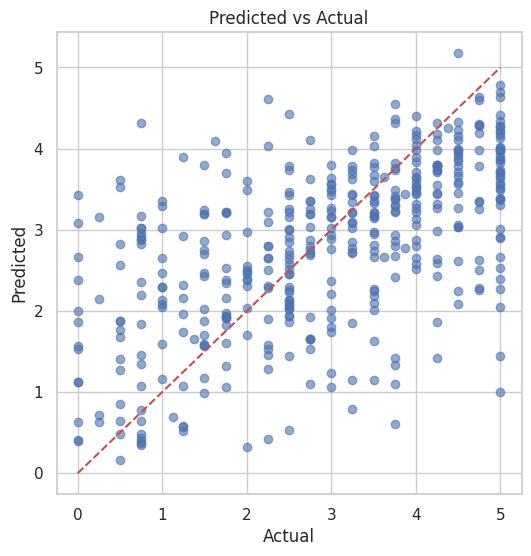

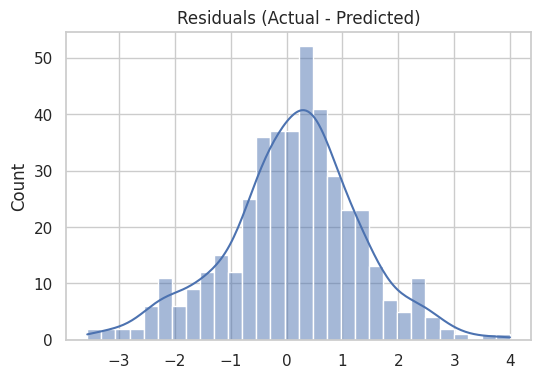

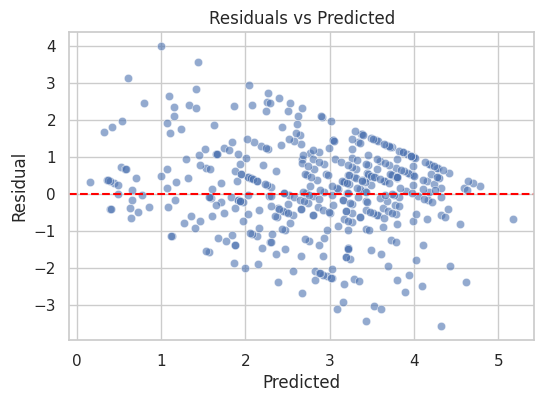

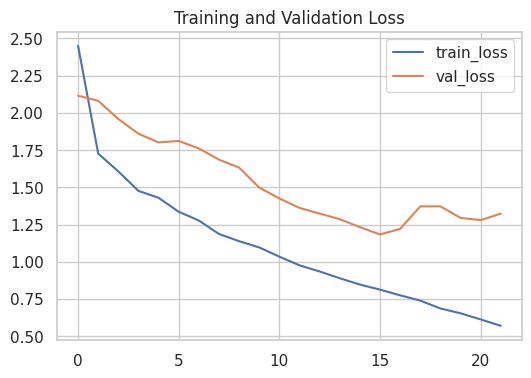

In [13]:
# 14. Diagnostic plots (predicted vs actual, residuals, error histogram, training curves)
def diagnostic_plots(y_true, y_pred, history=None):
    resid = y_true - y_pred
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Predicted vs Actual')
    plt.show()
    plt.figure(figsize=(6,4))
    sns.histplot(resid, bins=30, kde=True)
    plt.title('Residuals (Actual - Predicted)')
    plt.show()
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=y_pred, y=resid, alpha=0.6)
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.title('Residuals vs Predicted')
    plt.axhline(0, color='red', linestyle='--')
    plt.show()
    if history is not None:
        plt.figure(figsize=(6,4))
        plt.plot(history.history['loss'], label='train_loss')
        plt.plot(history.history['val_loss'], label='val_loss')
        plt.legend()
        plt.title('Training and Validation Loss')
        plt.show()

diagnostic_plots(y_test, y_test_pred, history=grid_results[0][0]['history'])


In [ ]:
# 15. Retrain best model on combined train+val and save to Drive (optional)
def retrain_and_save(best_config, X_train_full, y_train_full, X_test, y_test, sbert_model, save_to_drive=True, drive_dir=''):
    units = best_config['units']
    batch = best_config['batch']
    lr = best_config['lr']
    # Build model
    model = build_bilstm_model(X_train_full.shape[1], X_train_full.shape[2], lstm_units=units, learning_rate=lr)
    # Train
    hist = model.fit(X_train_full, y_train_full, epochs=30, batch_size=batch, validation_split=0.05, callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)])
    # Evaluate
    test_metrics, y_pred = evaluate_on_test(model, X_test, y_test)
    print('Retrained model test metrics:', test_metrics)
    # Save
    save_path = 'bilstm_best_model'
    model.save(save_path)
    sbert_model.save('sbert_encoder')
    print('Saved model to local path:', save_path)
    if save_to_drive:
        if not drive_dir:
            drive.mount('/content/drive')
            drive_dir = '/content/drive/MyDrive/arabic_asag_models'
        os.makedirs(drive_dir, exist_ok=True)
        import shutil
        shutil.copytree(save_path, os.path.join(drive_dir, save_path), dirs_exist_ok=True)
        shutil.copytree('sbert_encoder', os.path.join(drive_dir, 'sbert_encoder'), dirs_exist_ok=True)
        print('Copied models to Drive:', drive_dir)
    return model, hist

# Prepare combined train+val
X_train_combined = np.concatenate([X_train_seq, X_val_seq], axis=0)
y_train_combined = np.concatenate([y_train, y_val], axis=0)

best_conf = {'units': best_metrics['units'], 'batch': best_metrics['batch'], 'lr': best_metrics['lr']}
print('Retraining best configuration on combined train+val...')
final_model, final_hist = retrain_and_save(best_conf, X_train_combined, y_train_combined, X_test_seq, y_test, sbert, save_to_drive=False)


## Conclusion

This notebook implements a complete pipeline for Arabic short answer grading using Sentence-BERT embeddings and a BiLSTM regression model. It includes preprocessing, detailed exploratory analysis, hyperparameter tuning, diagnostic plots, and instructions to save models to Google Drive. For production use, consider the following improvements:
- Fine-tuning a transformer on ASAG pairs (token-level) rather than using fixed SBERT embeddings
- Larger, more balanced training data and cross-validation
- Ensembling models (e.g., SBERT cosine baseline + BiLSTM)
- Calibration of prediction scale if the `Average_Mark` has a specific range

If you want, I can adapt the grid search to use K-fold cross-validation or expand the hyperparameter search space.